## Cell 1: Import required libraries

In [1]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")


## Cell 2: Load the dataset

In [2]:

df = pd.read_csv("PRE_DEPARTURE_STUDENTS_MENTAL_HEALTH_SURVEY_EXTENDED.csv")
print(df.shape)
df.head()
print(df.columns.tolist())



(302, 31)
['Timestamp', '1. Age Group ', '2. Gender', '3. Academic Level', 'Destination Country', '5. How often do you feel overwhelmed by your responsibilities during pre departure preparation?', '6. How often do you feel nervous or on edge about going abroad?', '7. Do you find it difficult to relax when thinking about your upcoming move?', '8. How often do you worry about your ability to cope with challenges abroad?', '9. How often do you feel low energy or lack motivation due to pre_departure stress?', '10. How confident do you feel in handling emotional ups and downs during this transition?', '11. How anxious are you about visa delays or possible rejection?', '12. How often do you overthink potential problems that might happen abroad?', '13. How confident are you in your English/language communication skills?', '14. How stressed do you feel about adapting to a new cultural and academic environment?', '15. How satisfied are you with your current academic performance?', '16. Do you f

## Cell 3: Define depression-related survey columns

In [3]:
# Auto-detect depression-related questions by question number
question_numbers = ("5.", "6.", "7.", "8.", "9.", "10.", "11.", "12.", "13.", "14.", "30.")

depression_cols = [
    col for col in df.columns
    if col.strip().startswith(question_numbers)
]

print("Detected depression columns:")
for c in depression_cols:
    print(c)

print("Total detected:", len(depression_cols))


Detected depression columns:
5. How often do you feel overwhelmed by your responsibilities during pre departure preparation?
6. How often do you feel nervous or on edge about going abroad?
7. Do you find it difficult to relax when thinking about your upcoming move?
8. How often do you worry about your ability to cope with challenges abroad?
9. How often do you feel low energy or lack motivation due to pre_departure stress?
10. How confident do you feel in handling emotional ups and downs during this transition?
11. How anxious are you about visa delays or possible rejection?
12. How often do you overthink potential problems that might happen abroad?
13. How confident are you in your English/language communication skills?
14. How stressed do you feel about adapting to a new cultural and academic environment?
30. How stressed are you about leaving your family and friends?
Total detected: 11


## Cell 4: Convert depression columns to numeric and handle missing values

In [4]:

df[depression_cols] = df[depression_cols].apply(pd.to_numeric, errors="coerce")
df[depression_cols] = df[depression_cols].fillna(df[depression_cols].median())


## Cell 5: Reverse-code sleep column for consistent scale

In [5]:

sleep_col = "24. Do you get sufficient sleep (7_8_ hours) during the preparation period?"
df[sleep_col] = pd.to_numeric(df[sleep_col], errors="coerce")
df[sleep_col] = 6 - df[sleep_col]


## Cell 6: Create continuous depression score

In [6]:

df["Depression_Score"] = df[depression_cols].mean(axis=1)
df["Depression_Score"].describe()


count    302.000000
mean       3.177152
std        0.665106
min        1.500000
25%        2.600000
50%        3.300000
75%        3.600000
max        4.500000
Name: Depression_Score, dtype: float64

## Cell 7: Convert depression score into categorical target

In [7]:

def depression_level(score):
    if score <= 2.0:
        return "No/Minimal"
    elif score <= 3.0:
        return "Mild"
    elif score <= 4.0:
        return "Moderate"
    else:
        return "Severe"

df["Depression_Level"] = df["Depression_Score"].apply(depression_level)
df["Depression_Level"].value_counts()


Depression_Level
Moderate      152
Mild          102
Severe         27
No/Minimal     21
Name: count, dtype: int64

## Cell 8: Drop leakage columns used for target creation

In [8]:

df_model = df.drop(columns=depression_cols + ["Depression_Score"])


## Cell 9: Split features and target

In [9]:

X = df_model.drop(columns=["Depression_Level"])
y = df_model["Depression_Level"]


## Cell 10: Identify numeric and categorical columns

In [10]:

categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns


## Cell 11: Build preprocessing pipelines

In [11]:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


## Cell 12: Train-test split with stratification

In [12]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Cell 13: Random Forest baseline model

Random Forest Accuracy: 0.9344262295081968
Random Forest Weighted F1: 0.9335119343316066
              precision    recall  f1-score   support

        Mild       1.00      0.90      0.95        21
    Moderate       0.89      1.00      0.94        31
  No/Minimal       1.00      0.75      0.86         4
      Severe       1.00      0.80      0.89         5

    accuracy                           0.93        61
   macro avg       0.97      0.86      0.91        61
weighted avg       0.94      0.93      0.93        61



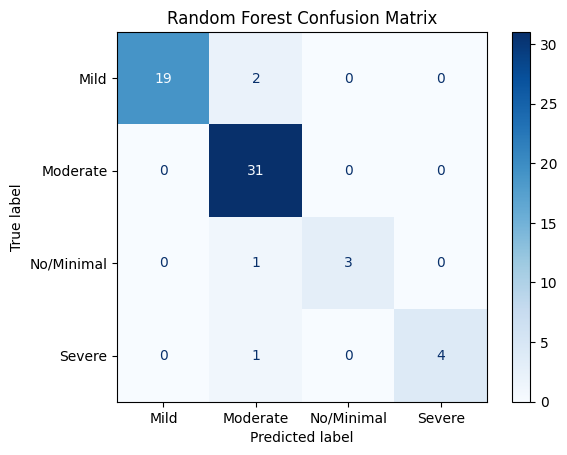

In [13]:

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Weighted F1:", f1_score(y_test, y_pred_rf, average="weighted"))
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()


## Cell 14: Random Forest hyperparameter tuning

In [14]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_param_dist = {
    "classifier__n_estimators": [200, 400, 600, 800],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 5]
}

rf_search = RandomizedSearchCV(
    rf_model,
    rf_param_dist,
    n_iter=20,
    scoring="f1_weighted",
    cv=cv,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)


Best RF params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None}


## Cell 15: Evaluate tuned Random Forest

Tuned RF Accuracy: 0.9508196721311475
Tuned RF Weighted F1: 0.9502241838307413
              precision    recall  f1-score   support

        Mild       1.00      0.90      0.95        21
    Moderate       0.91      1.00      0.95        31
  No/Minimal       1.00      1.00      1.00         4
      Severe       1.00      0.80      0.89         5

    accuracy                           0.95        61
   macro avg       0.98      0.93      0.95        61
weighted avg       0.96      0.95      0.95        61



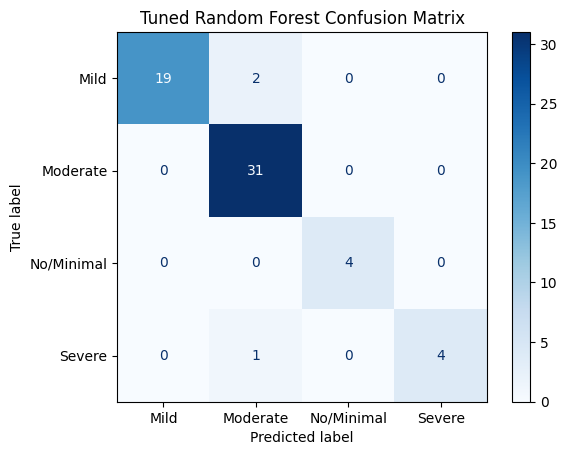

In [15]:

y_pred_rf_tuned = best_rf.predict(X_test)
print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("Tuned RF Weighted F1:", f1_score(y_test, y_pred_rf_tuned, average="weighted"))
print(classification_report(y_test, y_pred_rf_tuned))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tuned, cmap="Blues")
plt.title("Tuned Random Forest Confusion Matrix")
plt.show()


## Cell 16: LightGBM baseline model

LightGBM Accuracy: 0.9344262295081968
LightGBM Weighted F1: 0.9336110155782288
              precision    recall  f1-score   support

        Mild       1.00      0.86      0.92        21
    Moderate       0.89      1.00      0.94        31
  No/Minimal       1.00      1.00      1.00         4
      Severe       1.00      0.80      0.89         5

    accuracy                           0.93        61
   macro avg       0.97      0.91      0.94        61
weighted avg       0.94      0.93      0.93        61



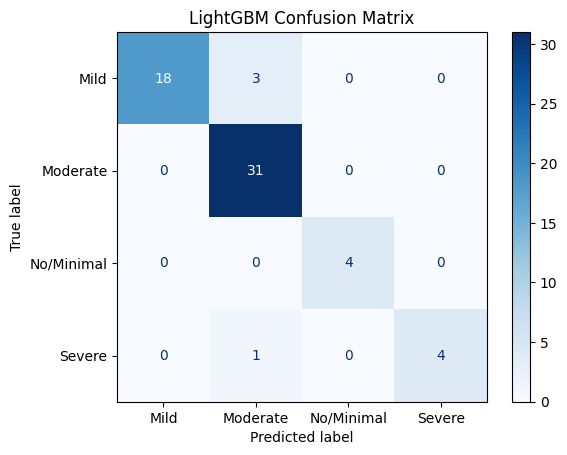

In [16]:

lgbm_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        verbose=-1,
        force_row_wise=True
    ))
])

lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("LightGBM Weighted F1:", f1_score(y_test, y_pred_lgbm, average="weighted"))
print(classification_report(y_test, y_pred_lgbm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm, cmap="Blues")
plt.title("LightGBM Confusion Matrix")
plt.show()


## Cell 17: LightGBM hyperparameter tuning

In [17]:

lgbm_param_dist = {
    "classifier__n_estimators": [400, 800, 1200],
    "classifier__learning_rate": [0.01, 0.03, 0.05],
    "classifier__num_leaves": [31, 63, 127],
    "classifier__max_depth": [-1, 5, 10],
    "classifier__min_child_samples": [5, 10, 20]
}

lgbm_search = RandomizedSearchCV(
    lgbm_model,
    lgbm_param_dist,
    n_iter=20,
    scoring="f1_weighted",
    cv=cv,
    random_state=42,
    n_jobs=-1
)

lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_
print("Best LGBM params:", lgbm_search.best_params_)


Best LGBM params: {'classifier__num_leaves': 31, 'classifier__n_estimators': 800, 'classifier__min_child_samples': 10, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.01}


## Cell 18: Evaluate tuned LightGBM

Tuned LightGBM Accuracy: 0.9344262295081968
Tuned LightGBM Weighted F1: 0.9328796930556228
              precision    recall  f1-score   support

        Mild       0.95      0.90      0.93        21
    Moderate       0.91      1.00      0.95        31
  No/Minimal       1.00      0.75      0.86         4
      Severe       1.00      0.80      0.89         5

    accuracy                           0.93        61
   macro avg       0.97      0.86      0.91        61
weighted avg       0.94      0.93      0.93        61



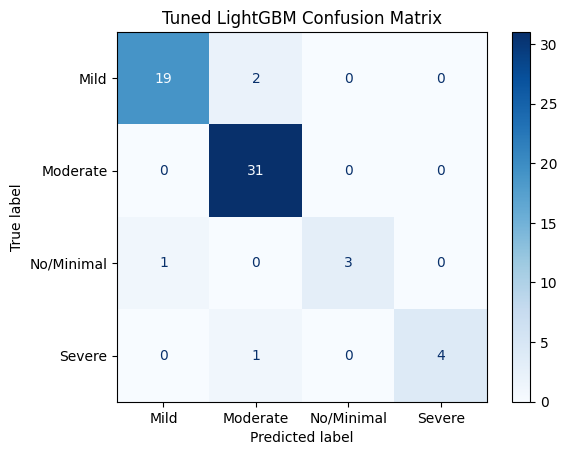

In [18]:

y_pred_lgbm_tuned = best_lgbm.predict(X_test)
print("Tuned LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm_tuned))
print("Tuned LightGBM Weighted F1:", f1_score(y_test, y_pred_lgbm_tuned, average="weighted"))
print(classification_report(y_test, y_pred_lgbm_tuned))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm_tuned, cmap="Blues")
plt.title("Tuned LightGBM Confusion Matrix")
plt.show()
